# A Scientific Deep Dive Into SageMaker LDA

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Training](#Training)
1. [Inference](#Inference)
1. [Epilogue](#Epilogue)

# Introduction
***

Amazon SageMaker LDA is an unsupervised learning algorithm that attempts to describe a set of observations as a mixture of distinct categories. Latent Dirichlet Allocation (LDA) is most commonly used to discover a user-specified number of topics shared by documents within a text corpus. Here each observation is a document, the features are the presence (or occurrence count) of each word, and the categories are the topics. Since the method is unsupervised, the topics are not specified up front, and are not guaranteed to align with how a human may naturally categorize documents. The topics are learned as a probability distribution over the words that occur in each document. Each document, in turn, is described as a mixture of topics.

This notebook is similar to **LDA-Introduction.ipynb** but its objective and scope are a different. We will be taking a deeper dive into the theory. The primary goals of this notebook are,

* to understand the LDA model and the example dataset,
* understand how the Amazon SageMaker LDA algorithm works,
* interpret the meaning of the inference output.

Former knowledge of LDA is not required. However, we will run through concepts rather quickly and at least a foundational knowledge of mathematics or machine learning is recommended. Suggested references are provided, as appropriate.

# Setup

***

*This notebook was created and tested on an ml.m4.xlarge notebook instance.*

We first need to specify some AWS credentials; specifically data locations and access roles. This is the only cell of this notebook that you will need to edit. In particular, we need the following data:

* `bucket` - An S3 bucket accessible by this account.
  * Used to store input training data and model data output.
  * Should be withing the same region as this notebook instance, training, and hosting.
* `prefix` - The location in the bucket where this notebook's input and and output data will be stored. (The default value is sufficient.)
* `role` - The IAM Role ARN used to give training and hosting access to your data.
  * See documentation on how to create these.
  * The script below will try to determine an appropriate Role ARN.

In [1]:
!conda install -y scipy

Solving environment: done

## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs:
    - scipy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    docutils-0.16              |           py36_0         668 KB
    ------------------------------------------------------------
                                           Total:         668 KB

The following packages will be DOWNGRADED:

  docutils                                      0.16-py36_1 --> 0.16-py36_0



docutils-0.16        | 668 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [2]:
%matplotlib inline

import os, re, tarfile

#import boto3
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# accessing the SageMaker Python SDK
from sagemaker.amazon.common import numpy_to_record_serializer
from sagemaker.predictor import csv_serializer, json_deserializer

In [3]:
!head -n 100 /home/ec2-user/SageMaker/chinese-corpus/toutiao_cat_data.txt

6551700932705387022_!_101_!_news_culture_!_京城最值得你来场文化之旅的博物馆_!_保利集团,马未都,中国科学技术馆,博物馆,新中国
6552368441838272771_!_101_!_news_culture_!_发酵床的垫料种类有哪些？哪种更好？_!_
6552407965343678723_!_101_!_news_culture_!_上联：黄山黄河黄皮肤黄土高原。怎么对下联？_!_
6552332417753940238_!_101_!_news_culture_!_林徽因什么理由拒绝了徐志摩而选择梁思成为终身伴侣？_!_
6552475601595269390_!_101_!_news_culture_!_黄杨木是什么树？_!_
6552387648126714125_!_101_!_news_culture_!_上联：草根登上星光道，怎么对下联？_!_
6552271725814350087_!_101_!_news_culture_!_什么是超写实绘画？_!_
6552452982015787268_!_101_!_news_culture_!_松涛听雨莺婉转，下联？_!_
6552400379030536455_!_101_!_news_culture_!_上联：老子骑牛读书，下联怎么对？_!_
6552339283632455939_!_101_!_news_culture_!_上联：山水醉人何须酒。如何对下联？_!_
6552387367334838792_!_101_!_news_culture_!_国画山水，如何读懂山水画_!_林风眠,黄海归来步步云,秋山图,计白当黑,山水画,江山万里图,张大千,巫峡清秋图,活眼,山雨欲来图
6552314684383429128_!_101_!_news_culture_!_一元硬币是这种，现在价值24000元，找找看！_!_牡丹,收藏价值
6552128476109865229_!_101_!_news_culture_!_有哪些让人感动的语句呢？_!_
6552447749072093453_!_101_!_news_culture_!_上联，绿竹引清风，如何对下联？_!_
6552301380562846215_!_101_!_news_culture_!_

In [4]:
!cat /home/ec2-user/SageMaker/chinese-corpus/toutiao_cat_data.txt | grep '_news_entertainment_' > toutiao_cat_data_ent.txt

In [5]:
!pip install jieba
!pip install ckiptagger 
!pip install tensorflow==1.13.1

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [6]:
import jieba.posseg as pseg
import json 
import numpy 
import sys 
max_feature_dim = 5000 
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sparse

sys.path.append('/home/ec2-user/SageMaker/nlp_processing/')

from preprocess import TouTiaoNewsPreprocessor
from segmenter import JiebaSegmenter
from transformer import BlazingTextInputDataTransformer



def to_dense_vectors(document_str, vocab_list): 
    vocab_dict = {} 
    vocab_inverse_dict = {} 
    for i, v in enumerate(vocab_list):
        vocab_dict[v] = i 
        vocab_inverse_dict[i] = v
        
    feature_dim = len(vocab_dict)
    vectors = [] 
    for d in document_str: 
        toks = d.split(' ')
        
        res = numpy.zeros(feature_dim)
        for t in toks:
            if t in vocab_dict:
                idx = vocab_dict[t]
                res[idx] += 1 
        vectors.append(res)
    return numpy.asarray(vectors),vocab_inverse_dict 
        
        


def to_sparse_vectors(documents, max_feature_dim): 
    vectorizer = CountVectorizer(input='content', analyzer='word', stop_words='english',max_features=max_feature_dim, max_df=0.95, min_df=2)
    vectors = vectorizer.fit_transform(documents)
    vocab_list = vectorizer.get_feature_names()

    vectors = sparse.csr_matrix(vectors, dtype=np.float32)
    return vectors, vocab_list

            

preprocessor = TouTiaoNewsPreprocessor()
res = preprocessor.preprocess('toutiao_cat_data_ent.txt')
segmenter = JiebaSegmenter()
transformer = BlazingTextInputDataTransformer()
document_str = [] 
for r in res:
    toks = segmenter.segment(r[2])
    document_str.append(' '.join(toks))    
    
print (document_str[0:10])    
documents, vocab_list = to_sparse_vectors(document_str, max_feature_dim)
vocabulary_size = len(vocab_list)
dense_docs,inverse_word_index = to_dense_vectors(document_str, vocab_list)
print(dense_docs[0:10])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-user/anaconda3/envs/python3

['谢娜 为 李浩菲 澄清 网络 谣言 ， 之后 她 的 两个 行为 给 自己 加 分', '谢娜 曾 为 他 与 主办方 撕破脸 ！ 谢娜 复出 快本 ！ 他 第一个 到场 支持 ！', '中国 网红竟 红到 美国 ？ 不多 说 了 ， 连小编 都 心动 了', '赵丽颖 很久没 有 登上 微博热 搜 了 ， 但 你们 别急 ， 她 只是 在 憋 大招 而已', '因戴 一个 眼镜 更 改变 气质 的 6 大 娱乐圈 明星 ， 你 最 喜欢 哪 一个', '后来 的 我们 ， 抢先 看', '超级 英雄 演员 颜值 身材 排名 ， 钢铁 侠 进不了 前 5 ， 第一名 很 意外', '《 无限 歌谣 季 》 热播   张绍 刚毛 不易 组合 似 “ 父子 ”', '张靓颖 透露 右耳 已经 间歇性 失聪 10 年 ， 这些 年 她 都 是 怎么 过来 的 啊', '成龙 改口 决定 不裸 捐 了 ， 20 亿 财产 给 儿子 一半 ， 你 怎么 看 ？']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [7]:
print(len(dense_docs))
print(type(dense_docs))
print(type(dense_docs[0]))


39396
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:

print('First training document =\n{}'.format(dense_docs[0]))
print('\nVocabulary size = {}'.format(vocabulary_size))
print('Length of first document = {}'.format(dense_docs[0].sum()))

First training document =
[0. 0. 0. ... 0. 0. 0.]

Vocabulary size = 5000
Length of first document = 8.0


## The LDA Model

As mentioned above, LDA is a model for discovering latent topics describing a collection of documents. In this section we will give a brief introduction to the model. Let,

* $M$ = the number of *documents* in a corpus
* $N$ = the average *length* of a document.
* $V$ = the size of the *vocabulary* (the total number of unique words)

We denote a *document* by a vector $w \in \mathbb{R}^V$ where $w_i$ equals the number of times the $i$th word in the vocabulary occurs within the document. This is called the "bag-of-words" format of representing a document.

$$
\underbrace{w}_{\text{document}} = \overbrace{\big[ w_1, w_2, \ldots, w_V \big] }^{\text{word counts}},
\quad
V = \text{vocabulary size}
$$

The *length* of a document is equal to the total number of words in the document: $N_w = \sum_{i=1}^V w_i$.

An LDA model is defined by two parameters: a topic-word distribution matrix $\beta \in \mathbb{R}^{K \times V}$ and a  Dirichlet topic prior $\alpha \in \mathbb{R}^K$. In particular, let,

$$\beta = \left[ \beta_1, \ldots, \beta_K \right]$$

be a collection of $K$ *topics* where each topic $\beta_k \in \mathbb{R}^V$ is represented as probability distribution over the vocabulary. One of the utilities of the LDA model is that a given word is allowed to appear in multiple topics with positive probability. The Dirichlet topic prior is a vector $\alpha \in \mathbb{R}^K$ such that $\alpha_k > 0$ for all $k$.

## Generating Documents

LDA is a generative model, meaning that the LDA parameters $(\alpha, \beta)$ are used to construct documents word-by-word by drawing from the topic-word distributions. In fact, looking closely at the example documents above you can see that some documents sample more words from some topics than from others.

LDA works as follows: given 

* $M$ documents $w^{(1)}, w^{(2)}, \ldots, w^{(M)}$,
* an average document length of $N$,
* and an LDA model $(\alpha, \beta)$.

**For** each document, $w^{(m)}$:
* sample a topic mixture: $\theta^{(m)} \sim \text{Dirichlet}(\alpha)$
* **For** each word $n$ in the document:
  * Sample a topic $z_n^{(m)} \sim \text{Multinomial}\big( \theta^{(m)} \big)$
  * Sample a word from this topic, $w_n^{(m)} \sim \text{Multinomial}\big( \beta_{z_n^{(m)}} \; \big)$
  * Add to document

The [plate notation](https://en.wikipedia.org/wiki/Plate_notation) for the LDA model, introduced in [2], encapsulates this process pictorially.

![](http://scikit-learn.org/stable/_images/lda_model_graph.png)

> [2] David M Blei, Andrew Y Ng, and Michael I Jordan. Latent Dirichlet Allocation. Journal of Machine Learning Research, 3(Jan):993–1022, 2003.

## Topic Mixtures

For the documents we generated above lets look at their corresponding topic mixtures, $\theta \in \mathbb{R}^K$. The topic mixtures represent the probablility that a given word of the document is sampled from a particular topic. For example, if the topic mixture of an input document $w$ is,

$$\theta = \left[ 0.3, 0.2, 0, 0.5, 0, \ldots, 0 \right]$$

then $w$ is 30% generated from the first topic, 20% from the second topic, and 50% from the fourth topic. In particular, the words contained in the document are sampled from the first topic-word probability distribution 30% of the time, from the second distribution 20% of the time, and the fourth disribution 50% of the time.


The objective of inference, also known as scoring, is to determine the most likely topic mixture of a given input document. Colloquially, this means figuring out which topics appear within a given document and at what ratios. We will perform infernece later in the [Inference](#Inference) section.

Since we generated these example documents using the LDA model we know the topic mixture generating them. Let's examine these topic mixtures.

# Training

***

In this section we will give some insight into how AWS SageMaker LDA fits an LDA model to a corpus, create an run a SageMaker LDA training job, and examine the output trained model.

## Store Data on S3

Before we run training we need to prepare the data.

A SageMaker training job needs access to training data stored in an S3 bucket. Although training can accept data of various formats we convert the documents MXNet RecordIO Protobuf format before uploading to the S3 bucket defined at the beginning of this notebook.

In [9]:
import sagemaker
from sagemaker import get_execution_role
import boto3
sess = sagemaker.Session()


bucket = 'cht-ws-nlp-yianc'
print(bucket)
role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

prefix = 'lda/entertainment_news' #Replace with the prefix under which you want to store the data if needed

print('Training input/output will be stored in {}/{}'.format(bucket, prefix))
print('\nIAM Role: {}'.format(role))

cht-ws-nlp-yianc
arn:aws:iam::702018522796:role/TeamRole
Training input/output will be stored in cht-ws-nlp-yianc/lda/travel_review

IAM Role: arn:aws:iam::702018522796:role/TeamRole


In [10]:
def numpy_to_protobuf_and_upload(sparray, bucket, prefix):
    recordio_protobuf_serializer = numpy_to_record_serializer()
    fbuffer = recordio_protobuf_serializer(sparray)

# upload to S3 in bucket/prefix/train
    fname = 'lda.data'
    s3_object = os.path.join(prefix, 'train', fname)
    boto3.Session().resource('s3').Bucket(bucket).Object(s3_object).upload_fileobj(fbuffer)

    s3_train_data = 's3://{}/{}'.format(bucket, s3_object)
    print('Uploaded data to S3: {}'.format(s3_train_data))
    return s3_train_data

    
s3_train_data = numpy_to_protobuf_and_upload(dense_docs, bucket, prefix)    
    

Uploaded data to S3: s3://cht-ws-nlp-yianc/lda/travel_review/train/lda.data


Next, we specify a Docker container containing the SageMaker LDA algorithm. For your convenience, a region-specific container is automatically chosen for you to minimize cross-region data communication

In [11]:
from sagemaker.amazon.amazon_estimator import get_image_uri

region_name = boto3.Session().region_name
container = get_image_uri(boto3.Session().region_name, 'lda')

print('Using SageMaker LDA container: {} ({})'.format(container, region_name))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Using SageMaker LDA container: 266724342769.dkr.ecr.us-west-2.amazonaws.com/lda:1 (us-west-2)


## Training Parameters

Particular to a SageMaker LDA training job are the following hyperparameters:

* **`num_topics`** - The number of topics or categories in the LDA model.
  * Usually, this is not known a priori.
  * In this example, howevever, we know that the data is generated by five topics.

* **`feature_dim`** - The size of the *"vocabulary"*, in LDA parlance.
  * In this example, this is equal 25.

* **`mini_batch_size`** - The number of input training documents.

* **`alpha0`** - *(optional)* a measurement of how "mixed" are the topic-mixtures.
  * When `alpha0` is small the data tends to be represented by one or few topics.
  * When `alpha0` is large the data tends to be an even combination of several or many topics.
  * The default value is `alpha0 = 1.0`.

In addition to these LDA model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.c4`
* Current limitations:
  * SageMaker LDA *training* can only run on a single instance.
  * SageMaker LDA does not take advantage of GPU hardware.
  * (The Amazon AI Algorithms team is working hard to provide these capabilities in a future release!)

Using the above configuration create a SageMaker client and use the client to create a training job.

In [12]:
session = sagemaker.Session()

document_nums = len(dense_docs)
# specify general training job information
lda = sagemaker.estimator.Estimator(
    container,
    role,
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    train_instance_count=1,
    train_instance_type='ml.m5.xlarge',
    sagemaker_session=session,
)
num_topics = 20
# set algorithm-specific hyperparameters
lda.set_hyperparameters(
    num_topics=num_topics,
    feature_dim=vocabulary_size,
    mini_batch_size=document_nums,
    alpha0=1.0,
)
# lda.set_hyperparameters(num_topics=num_topics, feature_dim=2149, mini_batch_size=128, 
#                         epochs=100, num_patience_epochs=5, tolerance=0.001)


from sagemaker.session import s3_input
s3_train = s3_input(s3_train_data) 

# run the training job on input data stored in S3
lda.fit({'train': s3_train})

2020-07-14 10:09:06 Starting - Starting the training job...
2020-07-14 10:09:08 Starting - Launching requested ML instances.........
2020-07-14 10:10:45 Starting - Preparing the instances for training...
2020-07-14 10:11:35 Downloading - Downloading input data......
2020-07-14 10:12:16 Training - Downloading the training image...
2020-07-14 10:12:58 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Using mxnet backend.
[07/14/2020 10:13:00 INFO 139658540201792] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'alpha0': u'1.0', u'max_restarts': u'10', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'allow_svd_init': u'true', u'epochs': u'1', u'tol': u'1e-8', u'_kvstore': u'local', u'max_iterations': u'1000'}
[07/14/2020 10:13:00 INFO 139658540201792] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': 

[07/14/2020 10:13:17 INFO 139658540201792] Krylov method iteration: 1.
[07/14/2020 10:13:21 INFO 139658540201792] Krylov method iteration: 2.
[07/14/2020 10:13:24 INFO 139658540201792] Krylov method iteration: 3.
[07/14/2020 10:13:27 INFO 139658540201792] Krylov method iteration: 4.
[07/14/2020 10:13:30 INFO 139658540201792] Krylov method iteration: 5.
[07/14/2020 10:13:34 INFO 139658540201792] Krylov method iteration: 6.
[07/14/2020 10:13:40 INFO 139658540201792] Covariance matrix min value: -0.000001
[07/14/2020 10:13:40 INFO 139658540201792] Covariance matrix max value: 0.000021
[07/14/2020 10:13:40 INFO 139658540201792] Starting SVD...
#metrics {"Metrics": {"svd.time": {"count": 1, "max": 10.089874267578125, "sum": 10.089874267578125, "min": 10.089874267578125}}, "EndTime": 1594721620.467388, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "LDA"}, "StartTime": 1594721594.543416}

[07/14/2020 10:13:40 INFO 139658540201792] Finished SVD.
#metrics {"Metrics": {"

[07/14/2020 10:13:56 INFO 139658540201792] [CPDecomp] Using line search: error_diff=5.78165054321e-06
[07/14/2020 10:13:56 INFO 139658540201792] [CPDecomp] Using line search: error_diff=2.20537185669e-06
[07/14/2020 10:13:56 INFO 139658540201792] [CPDecomp] Using line search: error_diff=3.12924385071e-06
[07/14/2020 10:13:56 INFO 139658540201792] [CPDecomp] Using line search: error_diff=3.03983688354e-06
[07/14/2020 10:13:56 INFO 139658540201792] [CPDecomp] Using line search: error_diff=2.6524066925e-06
[07/14/2020 10:13:56 INFO 139658540201792] [CPDecomp] Using line search: error_diff=2.23517417908e-06
[07/14/2020 10:13:56 INFO 139658540201792] [CPDecomp] Using line search: error_diff=1.57952308655e-06
[07/14/2020 10:13:56 INFO 139658540201792] [CPDecomp] Using line search: error_diff=4.47034835815e-07
[07/14/2020 10:13:56 INFO 139658540201792] [CPDecomp] Using line search: error_diff=2.4139881134e-06
[07/14/2020 10:13:56 INFO 139658540201792] [CPDecomp] Using line search: error_diff=

[07/14/2020 10:14:06 INFO 139658540201792] [CPDecomp] Using line search: error_diff=8.64267349243e-07
[07/14/2020 10:14:06 INFO 139658540201792] [CPDecomp] Using line search: error_diff=3.57627868652e-07
[07/14/2020 10:14:06 INFO 139658540201792] [CPDecomp] Using line search: error_diff=5.06639480591e-07
[07/14/2020 10:14:06 INFO 139658540201792] [CPDecomp] Using line search: error_diff=8.04662704468e-07
[07/14/2020 10:14:06 INFO 139658540201792] [CPDecomp] Using line search: error_diff=3.57627868652e-07
[07/14/2020 10:14:06 INFO 139658540201792] [CPDecomp] Using line search: error_diff=2.38418579102e-07
[07/14/2020 10:14:06 INFO 139658540201792] [CPDecomp] Using line search: error_diff=1.49011611938e-07
[07/14/2020 10:14:07 INFO 139658540201792] [CPDecomp] Using line search: error_diff=4.17232513428e-07
[07/14/2020 10:14:07 INFO 139658540201792] [CPDecomp] Using line search: error_diff=1.49011611938e-07
[07/14/2020 10:14:07 INFO 139658540201792] [CPDecomp] Using line search: error_dif


2020-07-14 10:14:26 Uploading - Uploading generated training model
2020-07-14 10:14:26 Completed - Training job completed


If you see the message

> `===== Job Complete =====`

at the bottom of the output logs then that means training sucessfully completed and the output LDA model was stored in the specified output path. You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below:

In [13]:
print('Training job name: {}'.format(lda.latest_training_job.job_name))

Training job name: lda-2020-07-14-10-09-06-624


# Inference

***

A trained model does nothing on its own. We now want to use the model we computed to perform inference on data. For this example, that means predicting the topic mixture representing a given document.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up.

In [14]:
lda_inference = lda.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',  # LDA inference may work better at scale on ml.c4 instances
)

-----------------!

Congratulations! You now have a functioning SageMaker LDA inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below: 

In [15]:
print('Endpoint name: {}'.format(lda_inference.endpoint))

Endpoint name: lda-2020-07-14-10-09-06-624


With this realtime endpoint at our fingertips we can finally perform inference on our training and test data.

We can pass a variety of data formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted, JSON-sparse-formatter, and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

In [16]:
lda_inference.content_type = 'text/csv'
lda_inference.serializer = csv_serializer
lda_inference.deserializer = json_deserializer

We pass some test documents to the inference endpoint. Note that the serializer and deserializer will atuomatically take care of the datatype conversion.

In [17]:
results = lda_inference.predict(dense_docs[:12])

print(results)

{'predictions': [{'topic_mixture': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [0.20289072394371033, 0.2569514214992523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5401578545570374, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [0.4165753126144409, 0.0, 0.5834246873855591, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [0.4544995129108429, 0.34957101941108704, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19592943787574768, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [0.8090415596961975, 0.0, 0.1909584403038025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

It may be hard to see but the output format of SageMaker LDA inference endpoint is a Python dictionary with the following format.

```
{
  'predictions': [
    {'topic_mixture': [ ... ] },
    {'topic_mixture': [ ... ] },
    {'topic_mixture': [ ... ] },
    ...
  ]
}
```

We extract the topic mixtures, themselves, corresponding to each of the input documents.

## Inference Analysis

Recall that although SageMaker LDA successfully learned the underlying topics which generated the sample data the topics were in a different order. Before we compare to known topic mixtures $\theta \in \mathbb{R}^K$ we should also permute the inferred topic mixtures


Let's plot these topic mixture probability distributions alongside the known ones.

In [18]:
predictions = np.array([prediction['topic_mixture'] for prediction in results['predictions']])
print(predictions)

[[1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.203 0.257 0.    0.    0.    0.    0.    0.    0.    0.54  0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.417 0.    0.583 0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.454 0.35  0.    0.    0.    0.    0.    0.    0.    0.    0.196 0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.809 0.    0.191 0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.37  0.63  0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.  

Text(0.5, 0, 'Topic ID')

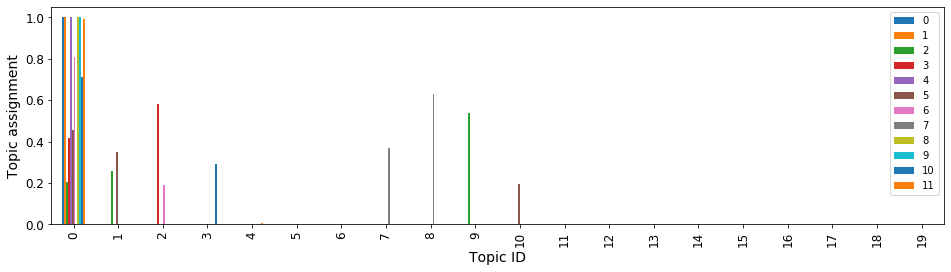

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
df=pd.DataFrame(predictions.T)
df.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

## Inspecting the Trained Model

We know the LDA parameters $(\alpha, \beta)$ used to generate the example data. How does the learned model compare the known one? In this section we will download the model data and measure how well SageMaker LDA did in learning the model.

First, we download the model data. SageMaker will output the model in 

> `s3://<bucket>/<prefix>/output/<training job name>/output/model.tar.gz`.

SageMaker LDA stores the model as a two-tuple $(\alpha, \beta)$ where each LDA parameter is an MXNet NDArray.

In [20]:
!pip install mxnet

     |████████████████████████████████| 68.7 MB 64.6 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [21]:
!rm model.tar.gz
!rm model_algo*

rm: cannot remove ‘model.tar.gz’: No such file or directory


In [22]:
# # download and extract the model file from S3
import mxnet as mx
job_name = lda.latest_training_job.job_name
print(job_name)
model_fname = 'model.tar.gz'
model_object = os.path.join(prefix, 'output', job_name, 'output', model_fname)
boto3.Session().resource('s3').Bucket(bucket).Object(model_object).download_file(model_fname)
model_object = os.path.join(prefix, 'output', job_name, 'output', model_fname)
boto3.Session().resource('s3').Bucket(bucket).Object(model_object).download_file(model_fname)
# model_object = "sagemaker/DEMO-lda-science/output/lda-2020-07-07-08-08-39-685/"


lda-2020-07-14-10-09-06-624


In [23]:
model_object = os.path.join(prefix, 'output', job_name, 'output', model_fname)
boto3.Session().resource('s3').Bucket(bucket).Object(model_object).download_file(model_fname)
with tarfile.open(model_fname) as tar:
    tar.extractall()
print('Downloaded and extracted model tarball: {}'.format(model_object))

# obtain the model file
model_list = [fname for fname in os.listdir('.') if fname.startswith('model_')]
model_fname = model_list[0]
print('Found model file: {}'.format(model_fname))

# get the model from the model file and store in Numpy arrays
alpha, beta = mx.ndarray.load('model_algo-1')
learned_alpha_permuted = alpha.asnumpy()
learned_beta_permuted = beta.asnumpy()

print('\nLearned alpha.shape = {}'.format(learned_alpha_permuted.shape))
print('Learned beta.shape = {}'.format(learned_beta_permuted.shape))

Downloaded and extracted model tarball: lda/travel_review/output/lda-2020-07-14-10-09-06-624/output/model.tar.gz
Found model file: model_algo-1

Learned alpha.shape = (20,)
Learned beta.shape = (20, 5000)


In [24]:
!pip install wordcloud

     |████████████████████████████████| 364 kB 5.5 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [25]:
!sudo yum install wqy-zenhei-fonts -y 
!sudo yum install cjkuni-fonts-common -y 
!sudo yum install cjkuni-fonts-ghostscript -y 
!sudo yum install cjkuni-ukai-fonts -y 
!sudo yum install cjkuni-uming-fonts -y 

Loaded plugins: dkms-build-requires, priorities, update-motd, upgrade-helper,
              : versionlock
amzn-main                                                | 2.1 kB     00:00     
amzn-updates                                             | 3.8 kB     00:00     
Resolving Dependencies
--> Running transaction check
---> Package wqy-zenhei-fonts.noarch 0:0.9.45-3.2.amzn1 will be installed
--> Finished Dependency Resolution

Dependencies Resolved

 Package               Arch        Version                 Repository      Size
Installing:
 wqy-zenhei-fonts      noarch      0.9.45-3.2.amzn1        amzn-main      8.8 M

Transaction Summary
Install  1 Package

Total download size: 8.8 M
Installed size: 16 M
wqy-zenhei-fonts-0.9.45-3.2.amzn1.noarch.rpm               | 8.8 MB   00:00     
Running transaction check
Running transaction test
Transaction test succeeded
Running transaction
  Installing : wqy-zenhei-fonts-0.9.45-3.2.amzn1.noarch                     1/1 
  Verifying  : wqy-zenhei

Loaded plugins: dkms-build-requires, priorities, update-motd, upgrade-helper,
              : versionlock
Existing lock /var/run/yum.pid: another copy is running as pid 23303.
Another app is currently holding the yum lock; waiting for it to exit...
  The other application is: yum
    Memory :  79 M RSS (326 MB VSZ)
    Started: Tue Jul 14 10:24:05 2020 - 00:01 ago
    State  : Running, pid: 23303
Package cjkuni-ukai-fonts-0.2.20080216.1-36.2.amzn1.noarch already installed and latest version
Nothing to do
Loaded plugins: dkms-build-requires, priorities, update-motd, upgrade-helper,
              : versionlock
Package cjkuni-uming-fonts-0.2.20080216.1-36.2.amzn1.noarch already installed and latest version
Nothing to do


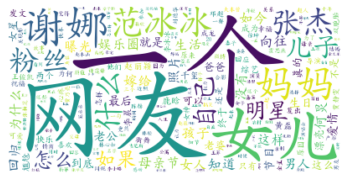

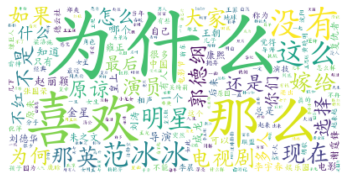

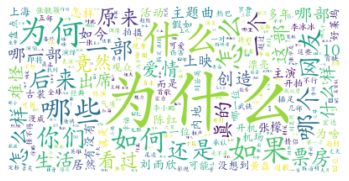

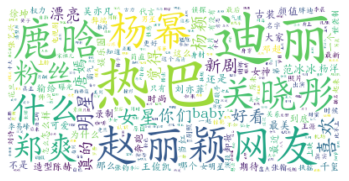

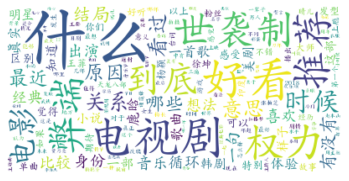

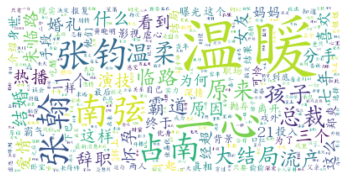

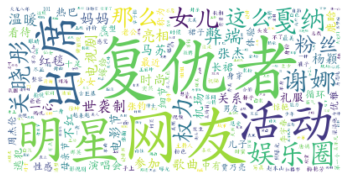

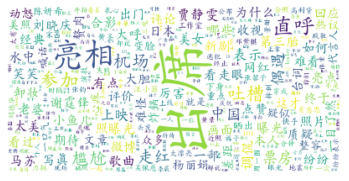

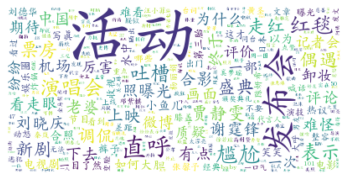

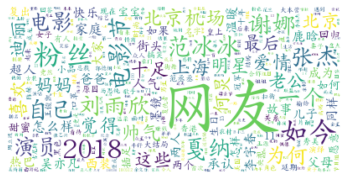

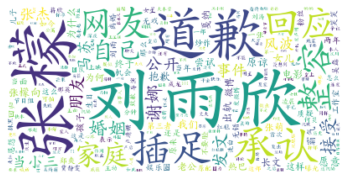

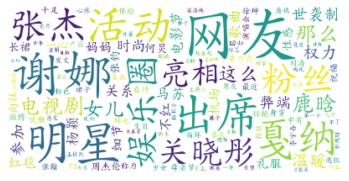

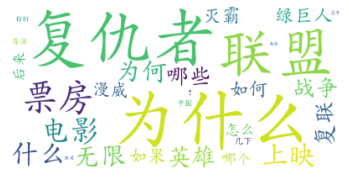

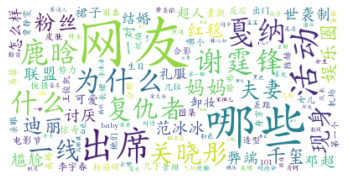

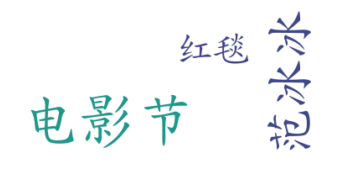

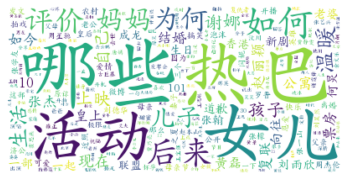

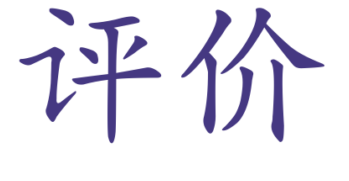

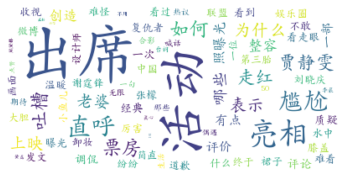

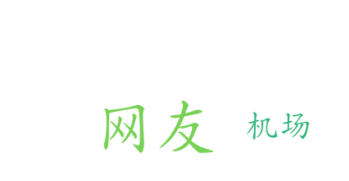

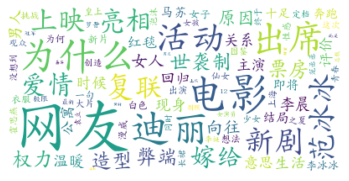

In [26]:

import PIL.Image as Image
from wordcloud import WordCloud 
topics_to_show = []
font_path = '/usr/share/fonts/cjkuni-ukai/ukai.ttc'
def makeImage(text):
#     alice_mask = np.array(Image.open("alice_mask.png"))

#     wc = WordCloud(font_path=font_path, background_color="white", max_words=1000)
    wc = WordCloud(font_path=font_path, background_color="white", max_words=1000)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()      


for beta in learned_beta_permuted: 
    topic_dic = {}
    for i, wi in enumerate(beta): 
        wc = inverse_word_index[i]
        topic_dic[wc] = wi*1000 
    makeImage(topic_dic)

  

Presumably, SageMaker LDA has found the topics most likely used to generate the training corpus. However, even if this is case the topics would not be returned in any particular order. Therefore, we match the found topics to the known topics closest in L1-norm in order to find the topic permutation.

Note that we will use the `permutation` later during inference to match known topic mixtures to found topic mixtures.

Below plot the known topic-word probability distribution, $\beta \in \mathbb{R}^{K \times V}$ next to the distributions found by SageMaker LDA as well as the L1-norm errors between the two.

## Stop / Close the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

In [27]:
sagemaker.Session().delete_endpoint(lda_inference.endpoint)

# Epilogue

---

In this notebook we,

* learned about the LDA model,
* generated some example LDA documents and their corresponding topic-mixtures,
* trained a SageMaker LDA model on a training set of documents and compared the learned model to the known model,
* created an inference endpoint,
* used the endpoint to infer the topic mixtures of a test input and analyzed the inference error.

There are several things to keep in mind when applying SageMaker LDA to real-word data such as a corpus of text documents. Note that input documents to the algorithm, both in training and inference, need to be vectors of integers representing word counts. Each index corresponds to a word in the corpus vocabulary. Therefore, one will need to "tokenize" their corpus vocabulary.

$$
\text{"cat"} \mapsto 0, \; \text{"dog"} \mapsto 1 \; \text{"bird"} \mapsto 2, \ldots
$$

Each text document then needs to be converted to a "bag-of-words" format document.

$$
w = \text{"cat bird bird bird cat"} \quad \longmapsto \quad w = [2, 0, 3, 0, \ldots, 0]
$$

Also note that many real-word applications have large vocabulary sizes. It may be necessary to represent the input documents in sparse format. Finally, the use of stemming and lemmatization in data preprocessing provides several benefits. Doing so can improve training and inference compute time since it reduces the effective vocabulary size. More importantly, though, it can improve the quality of learned topic-word probability matrices and inferred topic mixtures. For example, the words *"parliament"*, *"parliaments"*, *"parliamentary"*, *"parliament's"*, and *"parliamentarians"* are all essentially the same word, *"parliament"*, but with different conjugations. For the purposes of detecting topics, such as a *"politics"* or *governments"* topic, the inclusion of all five does not add much additional value as they all essentiall describe the same feature.